# Visualization graphs and results for Typhon

### Load Librairies

In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from pathlib import Path

### Put the path and select experiment to load

In [2]:
# import inspect 
  
# # print(inspect.signature(display))
# # print(inspect.signature(widgets.RadioButtons))
# print(inspect.getdoc(display))

In [3]:
# Make sure the path is correct, i.e. change according which experiment we want
# root_path = Path('results_atari')
root_path = Path('results')

experiments = sorted([path.stem for path in root_path.iterdir()])
exp_radiobuttons = widgets.RadioButtons(options=experiments, layout=widgets.Layout(width='600px')) # Add layout to avoid wrapping
display(exp_radiobuttons)

RadioButtons(layout=Layout(width='600px'), options=('000_old_20230419', '000_old_20230505', '20230429_bbd3_big…

### Use buttons to select the datasets, the metrics and other stuff

In [7]:
path = root_path / exp_radiobuttons.value / 'run_plot'
metrics_plot = pd.read_csv(path / 'metrics.csv')
 
datasets_checkboxes = [widgets.Checkbox(value=True, description=label) for label in pd.unique(metrics_plot['dataset'])]
datasets_vbox = widgets.VBox(children=datasets_checkboxes)
 
types_checkboxes = [widgets.Checkbox(value=True, description=label) for label in pd.unique(metrics_plot['type'])]
types_vbox = widgets.VBox(children=types_checkboxes)

fe_checkboxes = [widgets.Checkbox(value=True, description=label) for label in pd.unique(metrics_plot['feature_extractor'])]
fe_vbox = widgets.VBox(children=fe_checkboxes)

#metrics_checkboxes = [widgets.Checkbox(value=True if label=='loss' or label=='auc' else False, description=label) for label in pd.unique(metrics_plot['metric'])]
metrics_checkboxes = [widgets.Checkbox(value=True, description=label) for label in pd.unique(metrics_plot['metric'])]
# metrics_checkboxes = [widgets.Checkbox(value=True if label=='loss' else False, description=label) for label in pd.unique(metrics_plot['metric'])]
metrics_vbox = widgets.VBox(children=metrics_checkboxes)

vboxes = [datasets_vbox, types_vbox, fe_vbox, metrics_vbox]
output = widgets.HBox(children=vboxes)
display(output)

### Display the selected plots, and export it

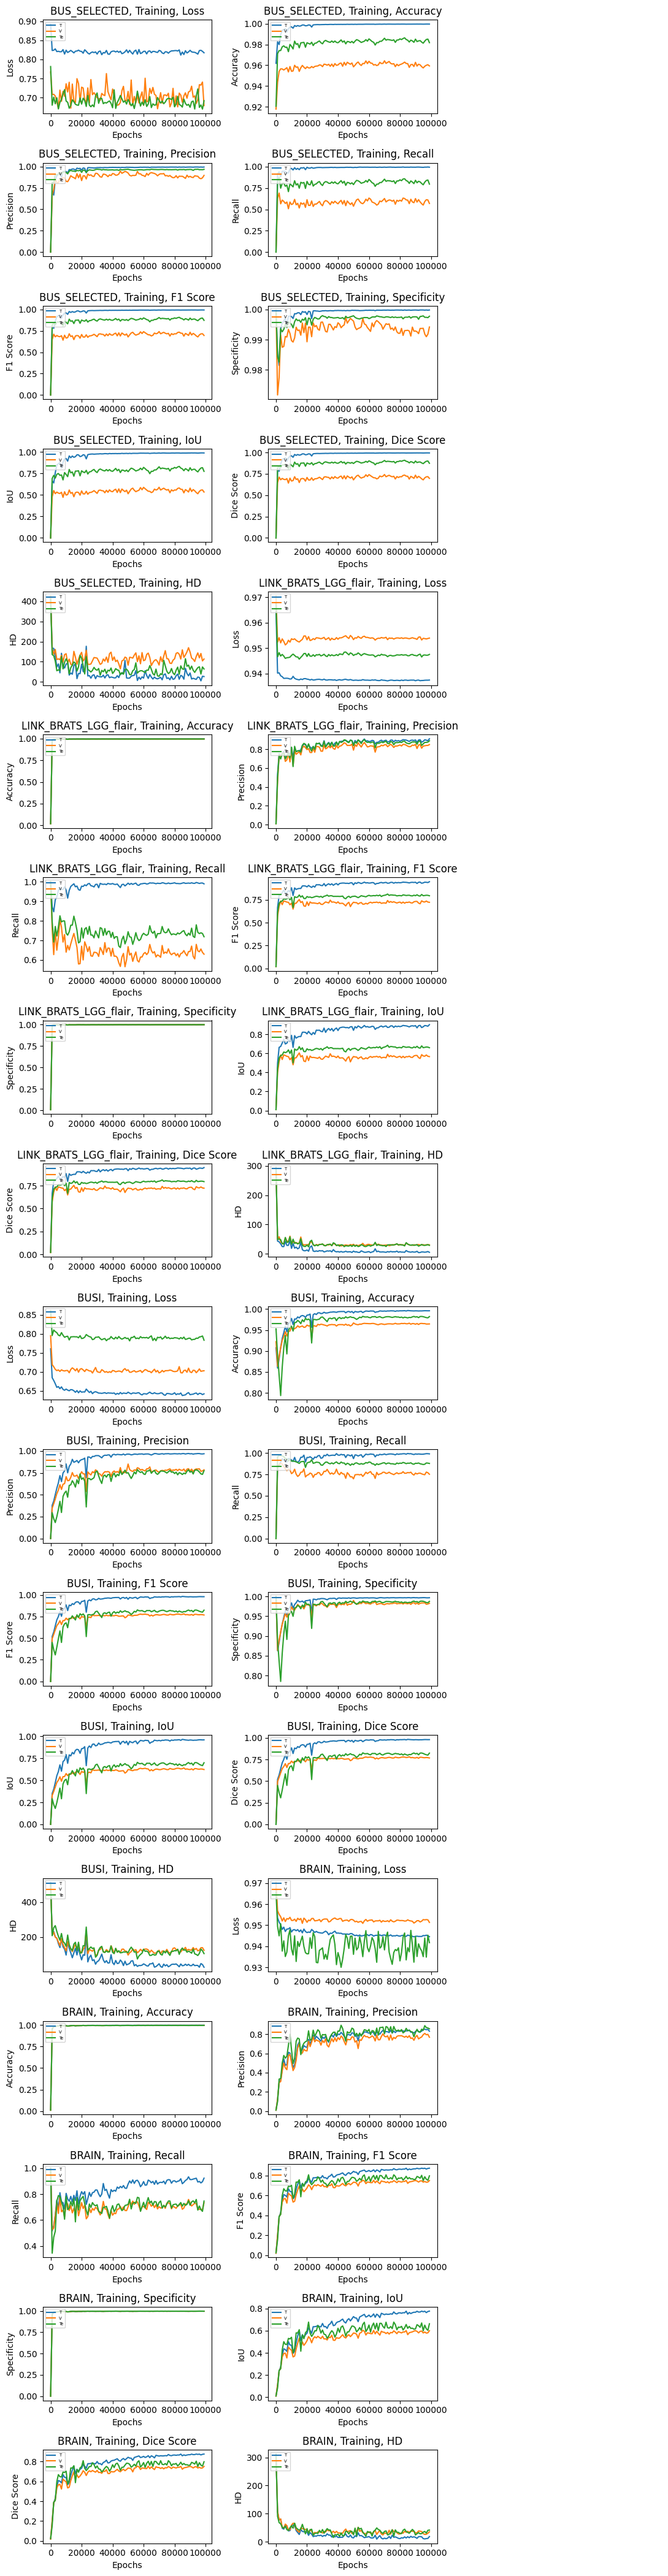

In [8]:
# Sometime big decrease in first 2/3 values makes y-axis big, and can't really see later changement
#  In these cases, start the plot from the 2nd/3rd value
START_EPOCH = 0

# Get the filter from the checkboxes
chosen_datasets = []
chosen_types = []
chosen_fe = []
chosen_metrics = []

for checkbox in datasets_checkboxes:
    if checkbox.value == True:
        chosen_datasets = chosen_datasets + [checkbox.description]
        
for checkbox in types_checkboxes:
    if checkbox.value == True:
        chosen_types = chosen_types + [checkbox.description]
        
for checkbox in fe_checkboxes:
    if checkbox.value == True:
        chosen_fe = chosen_fe + [checkbox.description]
        
for checkbox in metrics_checkboxes:
    if checkbox.value == True:
        chosen_metrics = chosen_metrics + [checkbox.description]

# Create figure
nplots = len(chosen_datasets)*len(chosen_types)*len(chosen_fe)*len(chosen_metrics)
fig, axes = plt.subplots(int(np.ceil(nplots / 2)), 3, figsize=(11,11.7/10*(nplots)), squeeze=False)

# Enable axes while plotting
for row in axes:
    for axis in row:
        axis.set_axis_off()
pos = 0

# Dict to use pretty print on the graphs
pretty_print = {
    'auc': 'AUC',
    'loss': 'Loss',
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1score': 'F1 Score',
    'specificity': 'Specificity',
    'trained': 'Training',
    'specialized': 'Specialization',
    'iou': 'IoU',
    'dice': 'Dice Score',
    'hd': 'HD'
}
        
# Create the plots
for dset_name in chosen_datasets:
    dset_metrics_plot = metrics_plot[metrics_plot['dataset'] == dset_name]
    
    # For specialization and trained
    for type_name in chosen_types:
        type_plot = dset_metrics_plot[dset_metrics_plot['type'] == type_name]
        
        # For frozen and unfrozen feature extractor
        for fe in chosen_fe:
            fe_plot = type_plot[type_plot['feature_extractor'] == fe]

            # Plots valset and trainset performance
            for idx, metric_name in enumerate(chosen_metrics):
                metric_name_plot = fe_plot[fe_plot['metric'] == metric_name]
                if metric_name_plot.empty: continue
                legends = []
                results_test = {}
                # Display the axes
                axes[int(np.floor(pos / 2)), pos % 2].set_axis_on()

                # For Split (train, validation and test)
                for split in pd.unique(metric_name_plot['split']):
                    split_plot = metric_name_plot[metric_name_plot['split'] == split]
#                     if split == 'test':
#                         results_test[metric_name] = split_plot['value'].values[0]
#                     else:    
                        # Cast the Pandas Series to a Python list
#                         points = [point if point <= 1 else point for point in split_plot['value']]
#                         axes[int(np.floor(pos / 2)), pos % 2].plot(split_plot['epoch'].iloc[START:], points[START:])
#                         legends.append(f"{'T' if split == 'train' else 'V'}")

                    # Ignore best value for test
                    split_plot = split_plot[split_plot['epoch'] != -1]
                    split_plot = split_plot[split_plot['epoch'] >= START_EPOCH]
                    points = [point if point <= 1 else point for point in split_plot['value']]
#                     axes[int(np.floor(pos / 2)), pos % 2].plot(split_plot['epoch'].iloc[START:], points[START:]
                    axes[int(np.floor(pos / 2)), pos % 2].plot(split_plot['epoch'], points)
                    legends.append(f"{'T' if split == 'train' else ('V' if split == 'validation' else 'Te')}")


            
            
            
                # Add legend, title and axes name
                if type_plot['epoch'].empty: continue
                number_epoch = max(type_plot['epoch'])
                axes[int(np.floor(pos / 2)), pos % 2].legend(legends, loc='upper left', fontsize=5)
                axes[int(np.floor(pos / 2)), pos % 2].set_title(f"{dset_name}, {pretty_print[type_name]}, {pretty_print[metric_name]}")
                axes[int(np.floor(pos / 2)), pos % 2].set_xlabel('Epochs')
                axes[int(np.floor(pos / 2)), pos % 2].set_ylabel(pretty_print[metric_name])

                # Print results of test
                try:
                    axes[int(np.floor(pos / 2)), 2].axis('off')
                    axes[int(np.floor(pos / 2)), 2].text(0, (pos % 2)*0.4, f"{pretty_print[metric_name]}={results_test[metric_name]}")
                except KeyError:
                    pass
                pos += 1
        
# Automatic padding between plots
fig.tight_layout()
plt.savefig(path / f"{exp_radiobuttons.value}.pdf")
plt.show()

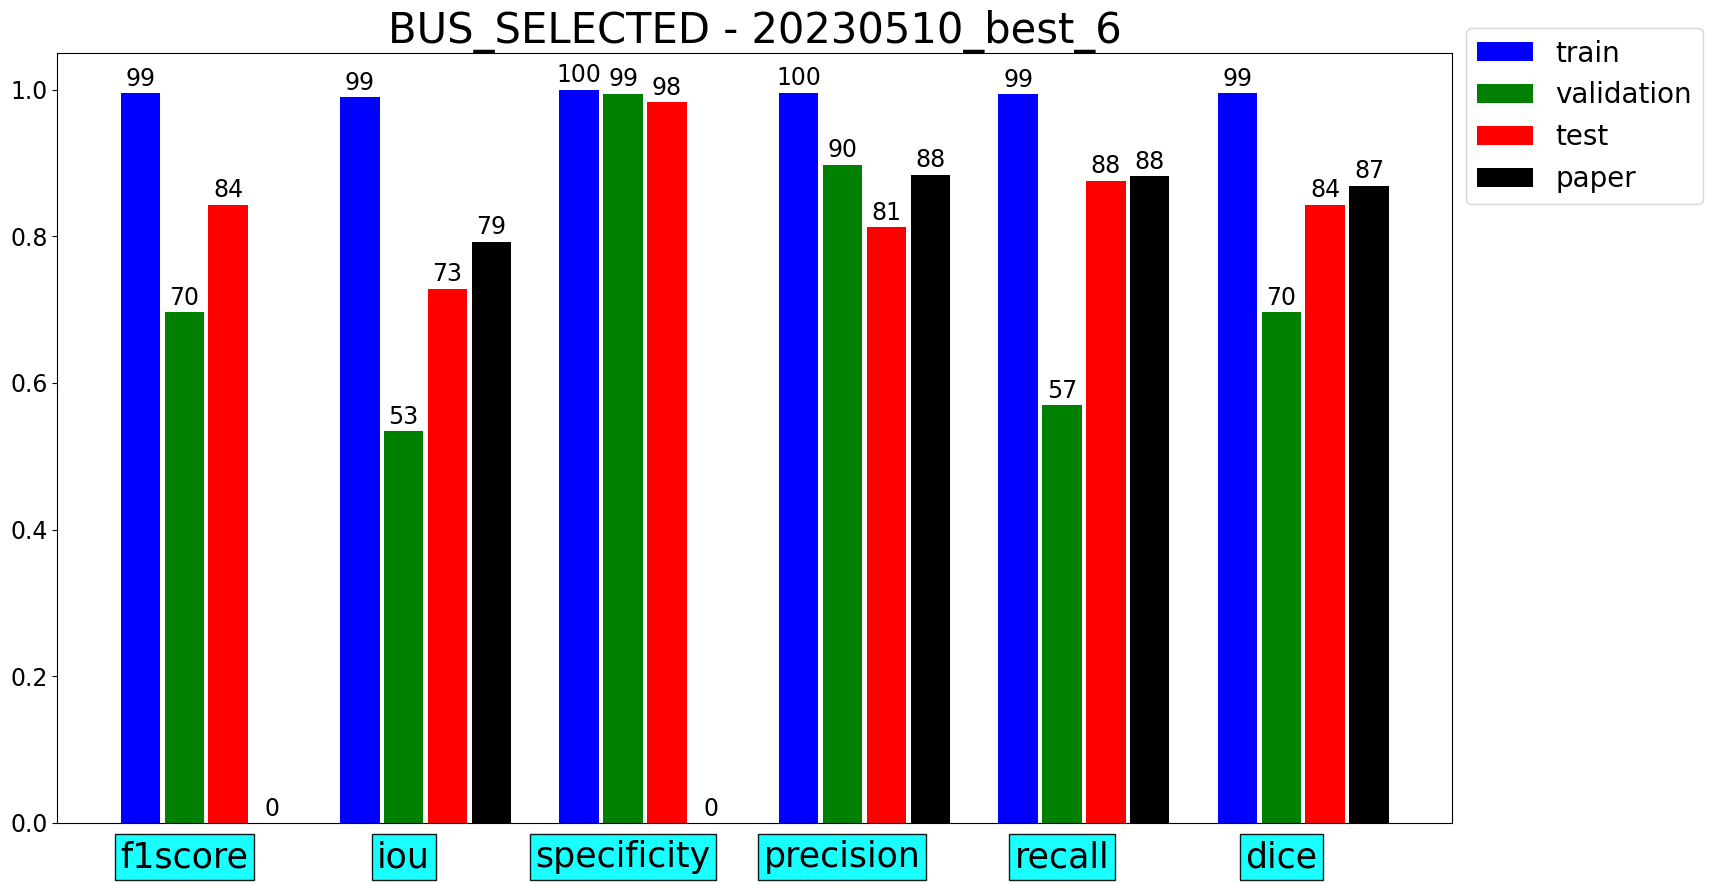

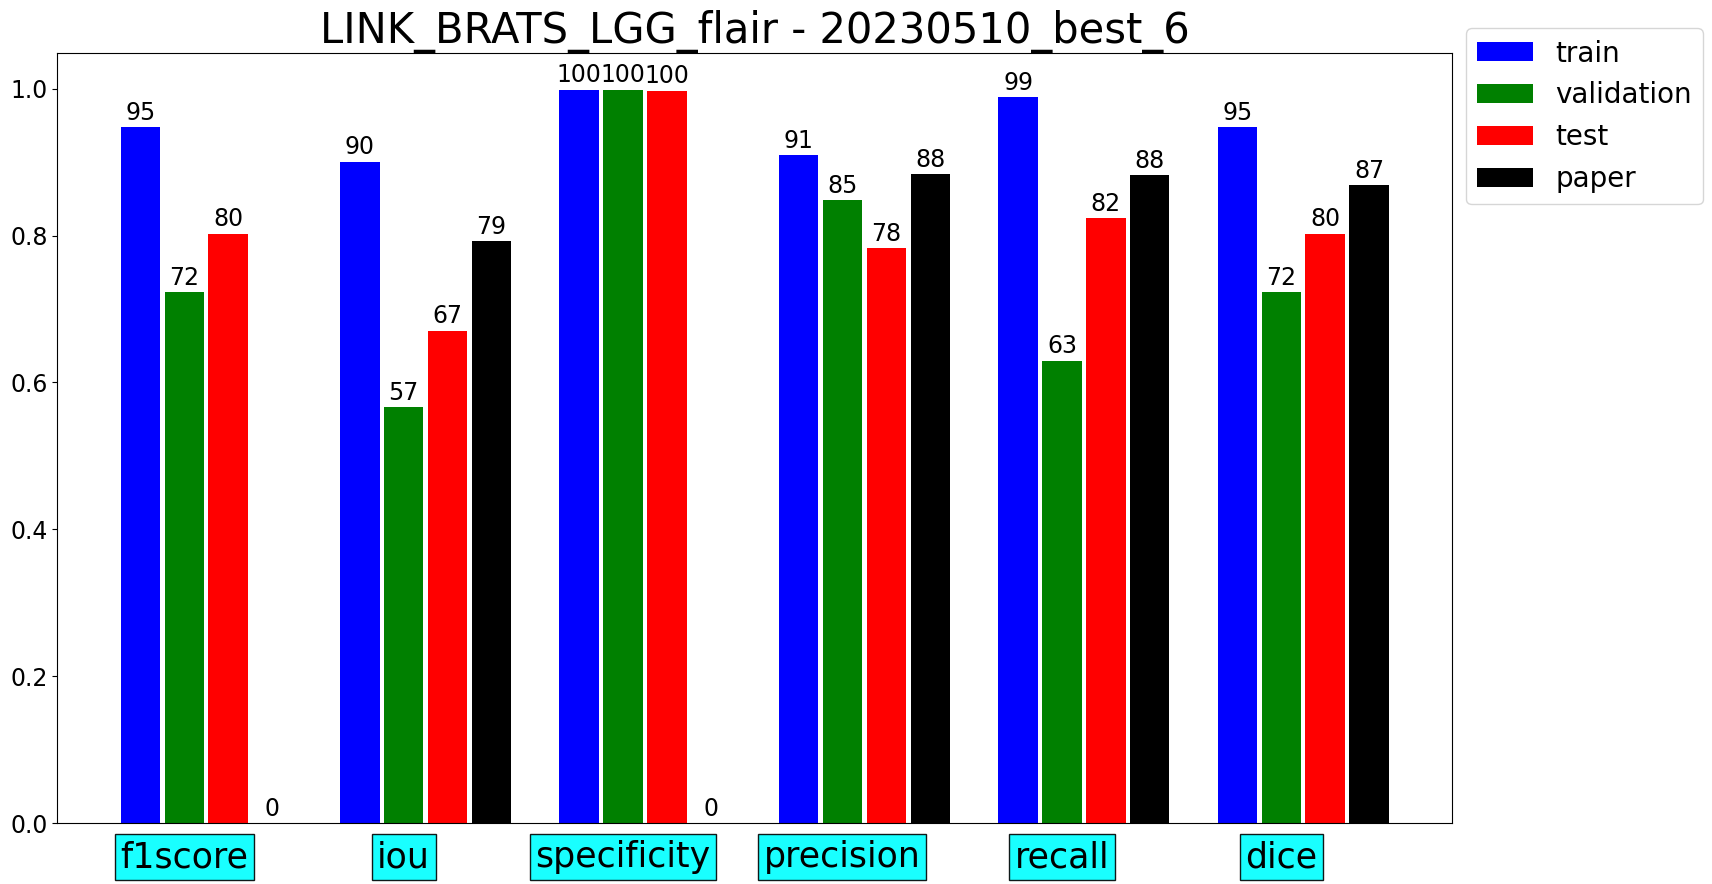

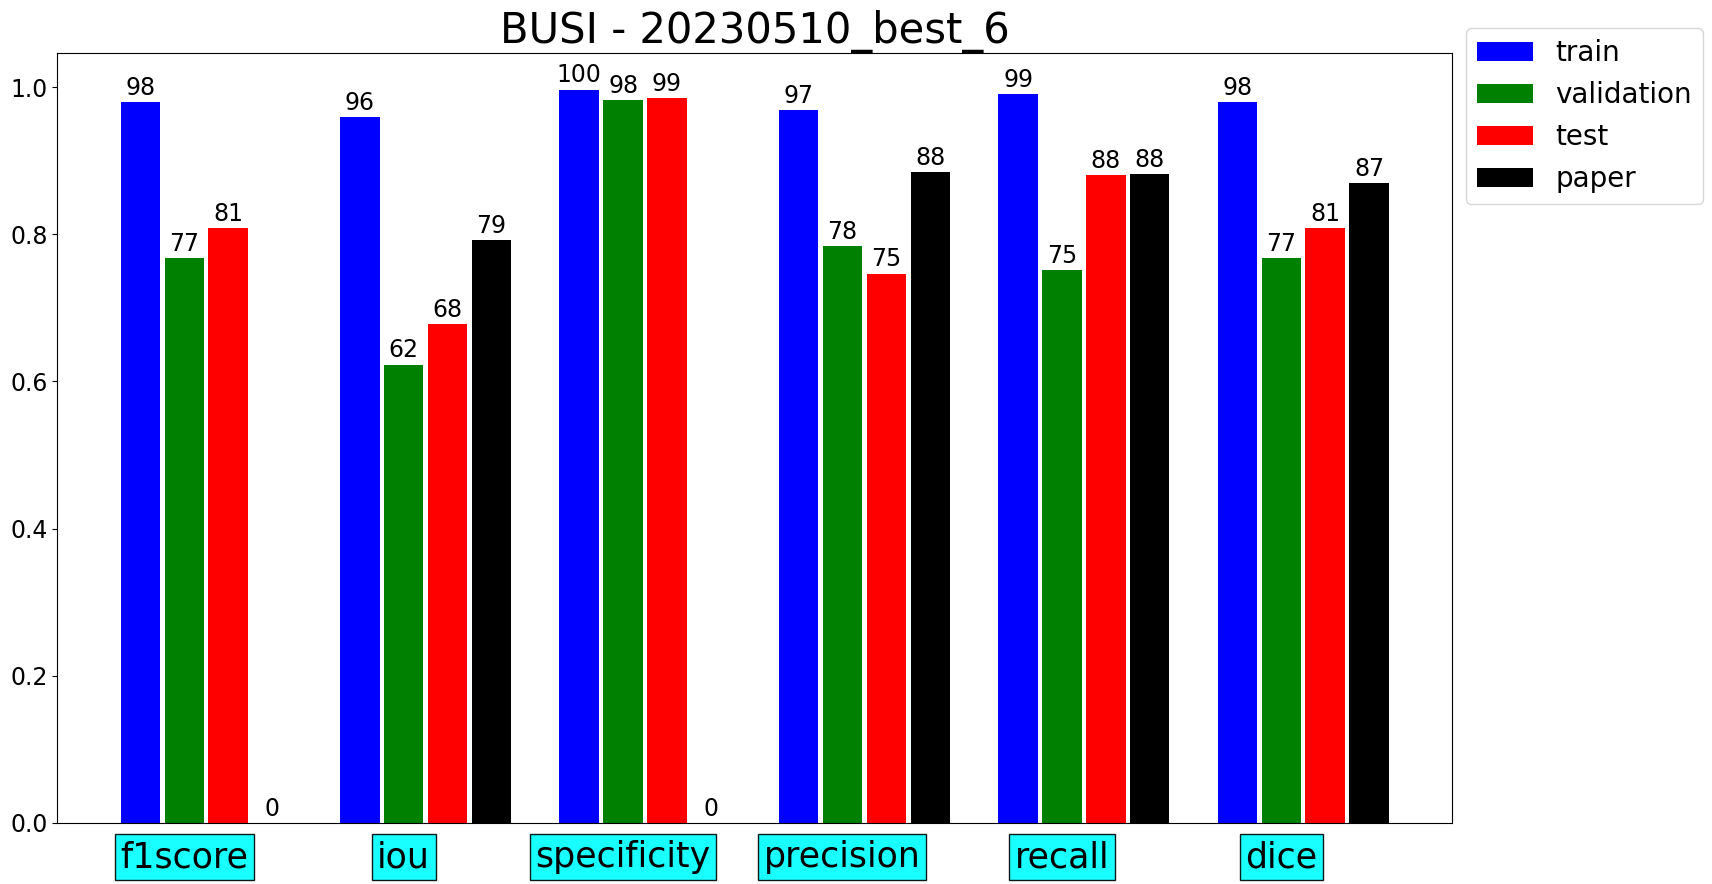

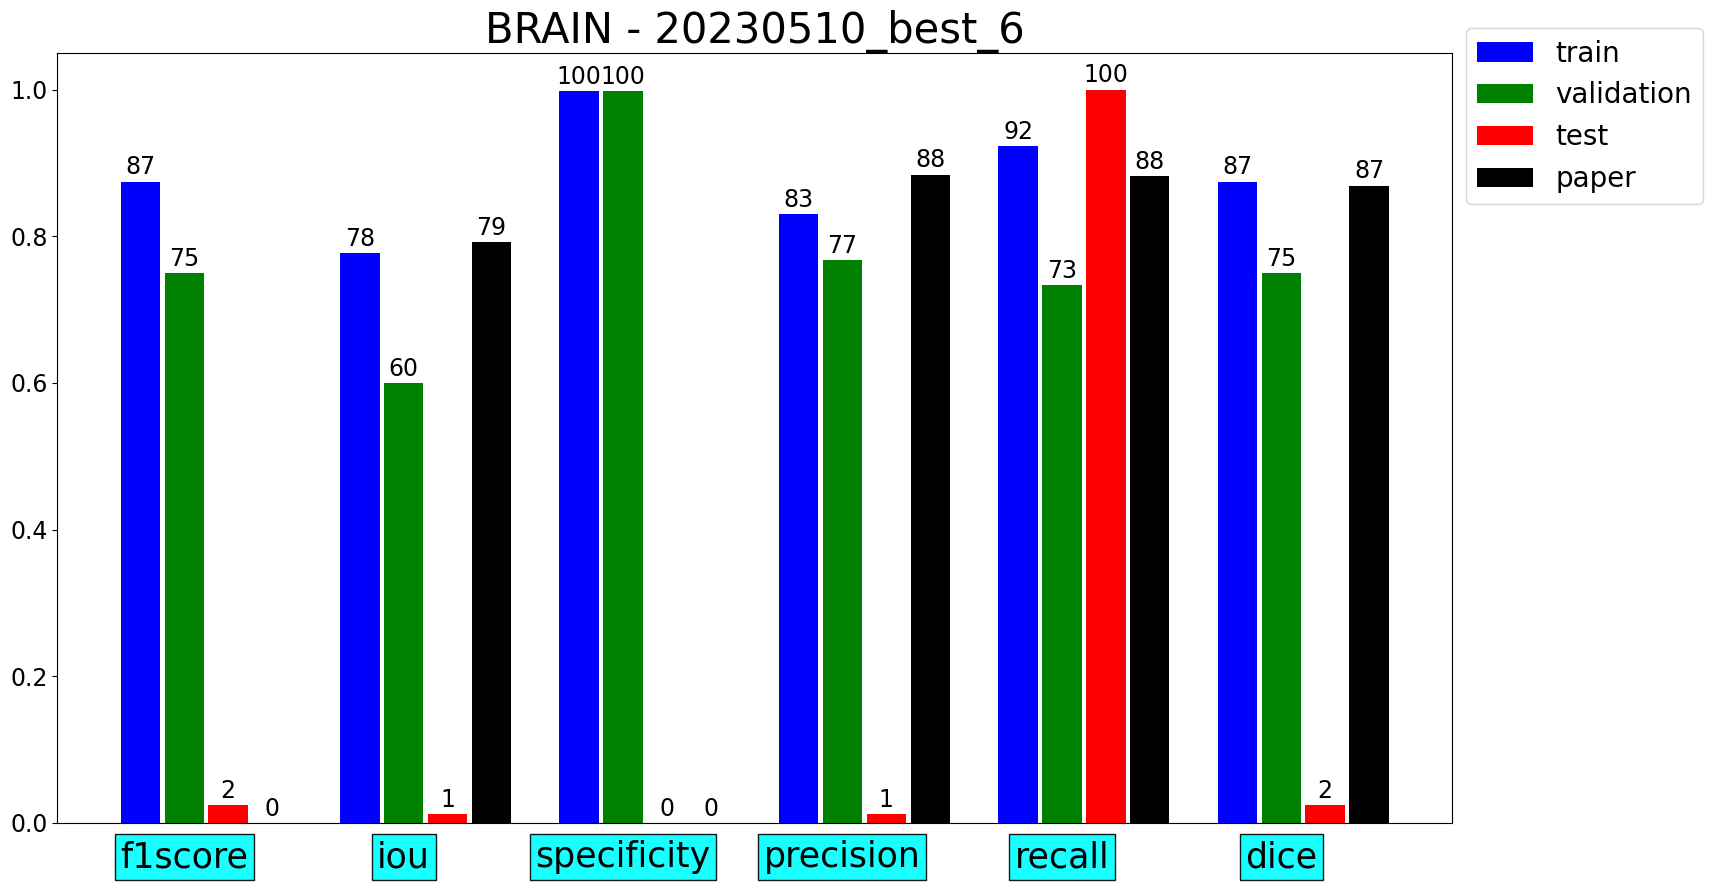

In [9]:
def add_labels(x,y):
    for i, xv in enumerate(x):
#         plt.text(xv, y[i] + 0.01, int(y[i] * 100), fontsize=17, ha='center')
        plt.text(xv, y[i] + 0.01, int(round(y[i] * 100)), fontsize=17, ha='center')
        
def add_metrics(x,txts):
    for i, xv in enumerate(x):
        t = plt.text(xv, - 0.06, txts[i], fontsize=25, ha='center')
        t.set_bbox(dict(facecolor='aqua', alpha=0.9, edgecolor='black'))

for dset_name in chosen_datasets:
    dset_metrics_plot = metrics_plot[metrics_plot['dataset'] == dset_name]
    
    # For specialization and trained
    for type_name in chosen_types:
        type_plot = dset_metrics_plot[dset_metrics_plot['type'] == type_name]
        
        # For frozen and unfrozen feature extractor
        for fe in chosen_fe:
            fe_plot = type_plot[type_plot['feature_extractor'] == fe]

            metrics_values = {s:[] for s in pd.unique(metric_name_plot['split'])}
            
            # Hardcode metrics order to match paper
            chosen_metrics_hardcoded = ['f1score', 'iou', 'specificity', 'precision', 'recall', 'dice'] #, 'auc']
            chosen_metrics = chosen_metrics_hardcoded
            
            # Get metrics scores
            for idx, metric_name in enumerate(chosen_metrics):
                metric_name_plot = fe_plot[fe_plot['metric'] == metric_name]
                
                # For Split (train, validation and test)
                for split in pd.unique(metric_name_plot['split']):
                    split_plot = metric_name_plot[metric_name_plot['split'] == split]
                    if split == 'test':
                        split_plot = split_plot[split_plot['epoch'] == -1]
                        # Get value
                        metrics_values[split].append(split_plot['value'].values[0])
                    else:
                        # Get last index
                        metrics_values[split].append(split_plot['value'].iat[-1])

                     
            colors = {
                'train': 'blue',
                'validation': 'green',
                'test': 'red',
                'paper': 'black'
            }
            metrics_values['paper'] = [0, 0.7924, 0, 0.884, 0.8822, 0.8691]
            # JI == IoU (or not?)
            
            width = 0.2
            plt.figure(figsize=(18,10))
            plt.xticks([], []) # Remove x-ticks
            plt.yticks(fontsize=17) # Change font size of y-ticks
            plt.bar(np.arange(len(metrics_values['train'])), metrics_values['train'], width=.9*width, label='train', color=colors['train'])
            add_labels(np.arange(len(metrics_values['train'])), metrics_values['train'])
            plt.bar(np.arange(len(metrics_values['validation'])) + width, metrics_values['validation'], width=.9*width, label='validation', color=colors['validation'])
            add_labels(np.arange(len(metrics_values['validation'])) + width, metrics_values['validation'])
            add_metrics(np.arange(len(metrics_values['validation'])) + width, chosen_metrics)
            try:
                plt.bar(np.arange(len(metrics_values['test'])) + 2*width, metrics_values['test'], width=.9*width, label='test', color=colors['test'])
                add_labels(np.arange(len(metrics_values['test'])) + 2*width, metrics_values['test'])
            except: 
                print('Test metrics not yet computed, wait for end of the training')
            plt.bar(np.arange(len(metrics_values['paper'])) + 3*width, metrics_values['paper'], width=.9*width, label='paper', color=colors['paper'])
            add_labels(np.arange(len(metrics_values['paper'])) + 3*width, metrics_values['paper'])
            
            plt.title(dset_name + ' - ' + exp_radiobuttons.value, fontsize=30)
            plt.legend(fontsize=20, bbox_to_anchor=(1.0, 1.05))
            
            plt.savefig(path / f"{exp_radiobuttons.value}_{dset_name}_hist.pdf")
            plt.show()

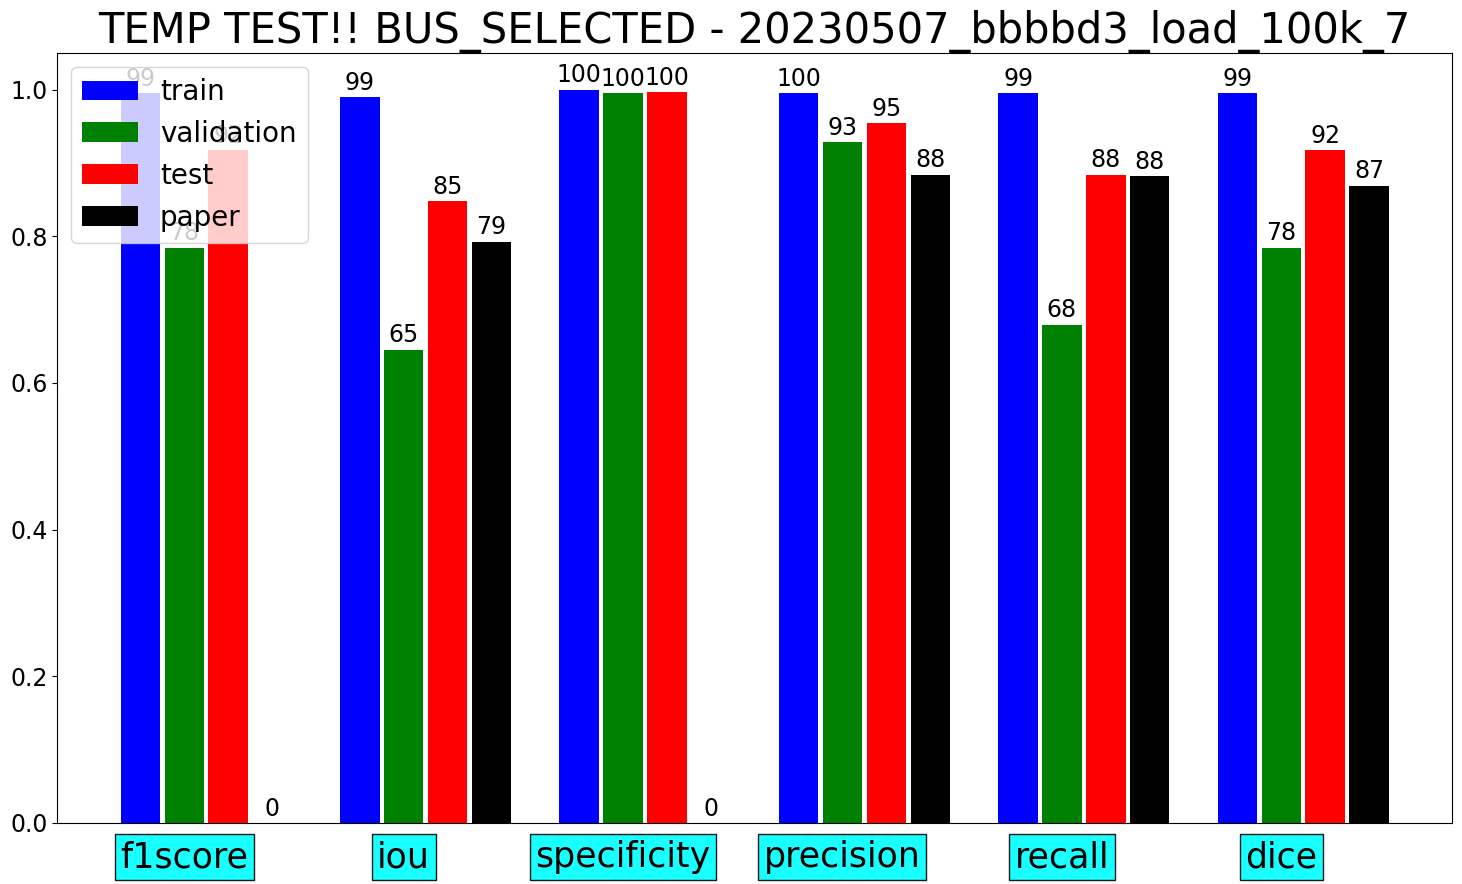

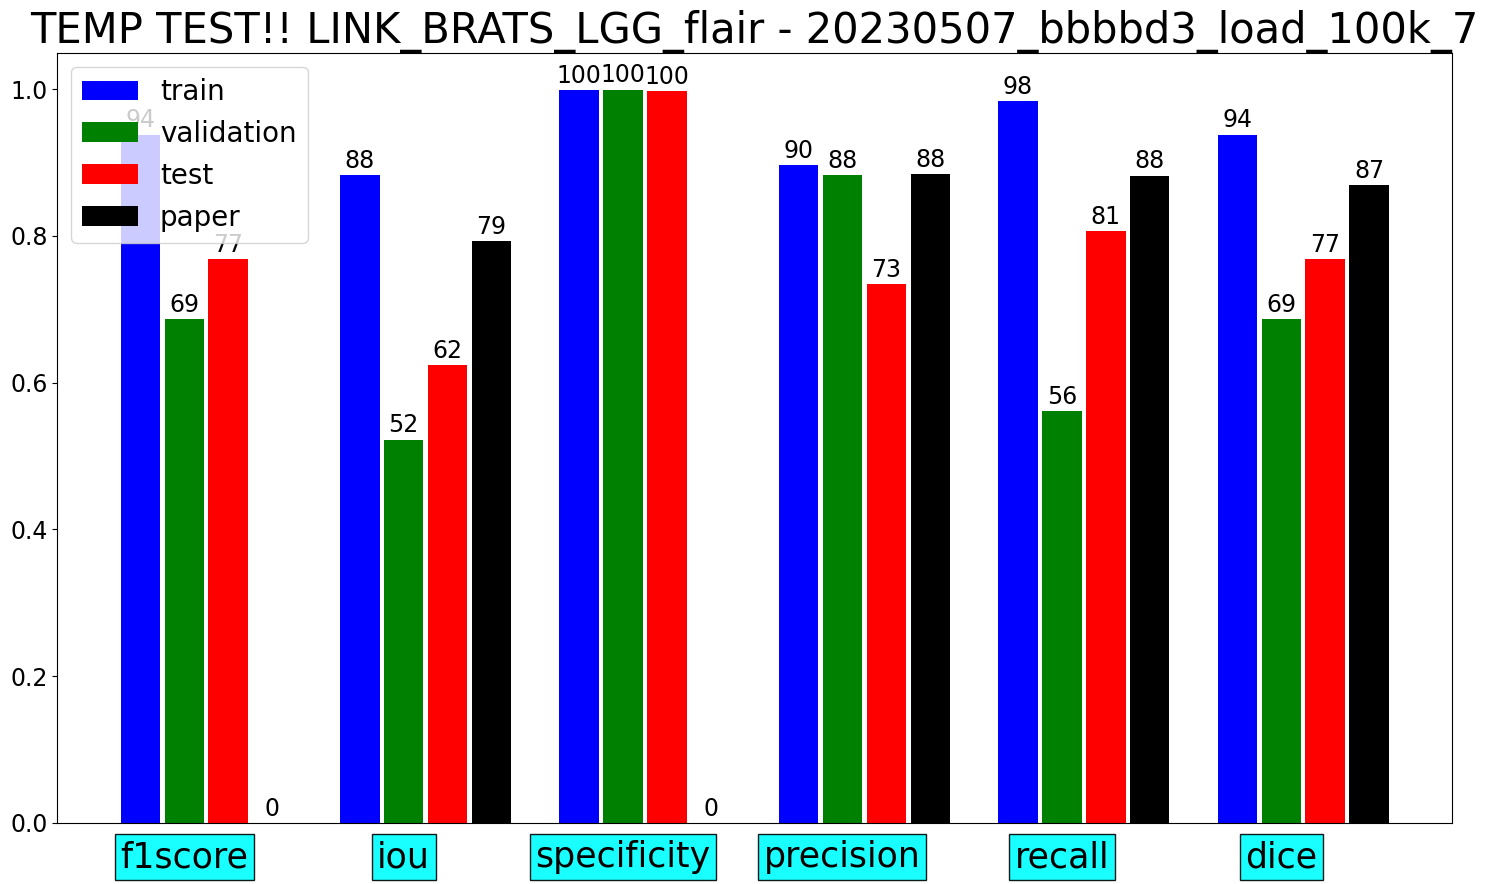

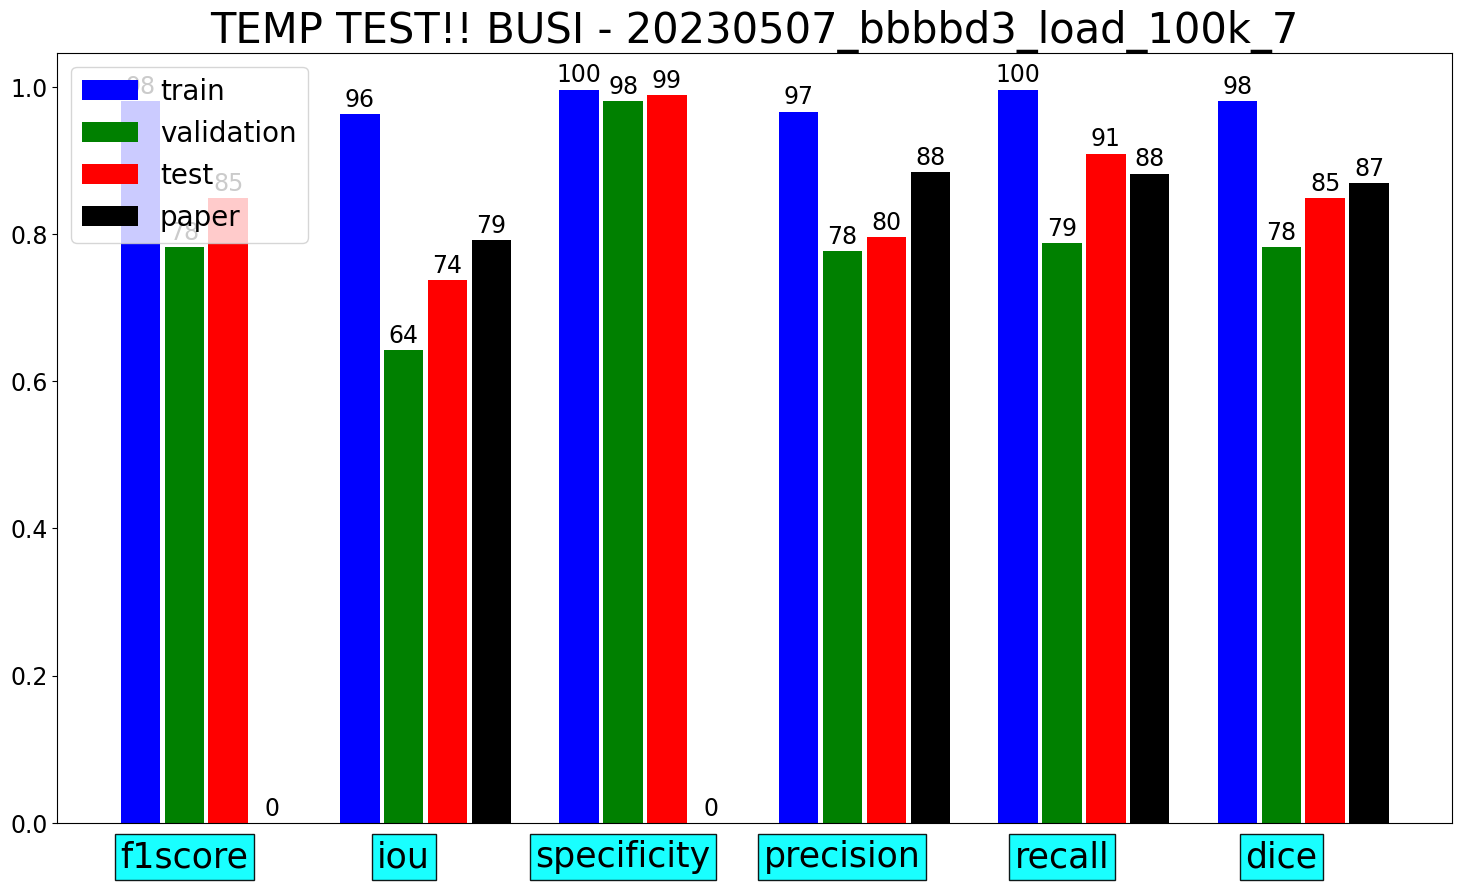

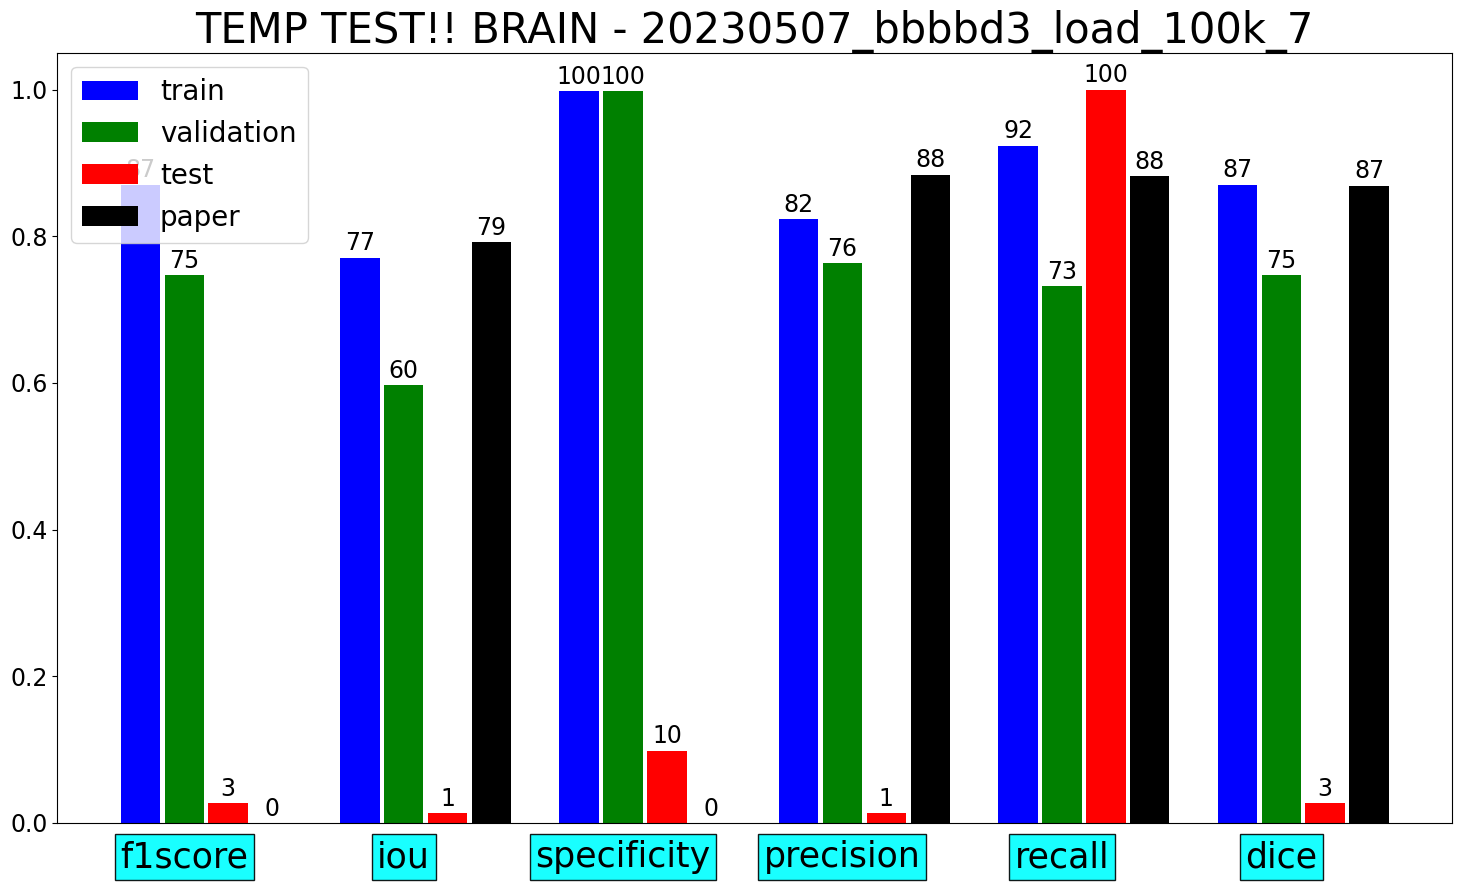

In [53]:
def add_labels(x,y):
    for i, xv in enumerate(x):
#         plt.text(xv, y[i] + 0.01, int(y[i] * 100), fontsize=17, ha='center')
        plt.text(xv, y[i] + 0.01, int(round(y[i] * 100)), fontsize=17, ha='center')
        
def add_metrics(x,txts):
    for i, xv in enumerate(x):
        t = plt.text(xv, - 0.06, txts[i], fontsize=25, ha='center')
        t.set_bbox(dict(facecolor='aqua', alpha=0.9, edgecolor='black'))

for dset_name in chosen_datasets:
    dset_metrics_plot = metrics_plot[metrics_plot['dataset'] == dset_name]
    
    # For specialization and trained
    for type_name in chosen_types:
        type_plot = dset_metrics_plot[dset_metrics_plot['type'] == type_name]
        
        # For frozen and unfrozen feature extractor
        for fe in chosen_fe:
            fe_plot = type_plot[type_plot['feature_extractor'] == fe]

            metrics_values = {s:[] for s in pd.unique(metric_name_plot['split'])}
            
            # Hardcode metrics order to match paper
            chosen_metrics_hardcoded = ['f1score', 'iou', 'specificity', 'precision', 'recall', 'dice'] #, 'auc']
            chosen_metrics = chosen_metrics_hardcoded
            
            # Get metrics scores
            for idx, metric_name in enumerate(chosen_metrics):
                metric_name_plot = fe_plot[fe_plot['metric'] == metric_name]
                
                # For Split (train, validation and test)
                for split in pd.unique(metric_name_plot['split']):
                    split_plot = metric_name_plot[metric_name_plot['split'] == split]
                    metrics_values[split].append(split_plot['value'].iat[-1])

                     
            colors = {
                'train': 'blue',
                'validation': 'green',
                'test': 'red',
                'paper': 'black'
            }
            metrics_values['paper'] = [0, 0.7924, 0, 0.884, 0.8822, 0.8691]
            # JI == IoU (or not?)
            
            width = 0.2
            plt.figure(figsize=(18,10))
            plt.xticks([], []) # Remove x-ticks
            plt.yticks(fontsize=17) # Change font size of y-ticks
            plt.bar(np.arange(len(metrics_values['train'])), metrics_values['train'], width=.9*width, label='train', color=colors['train'])
            add_labels(np.arange(len(metrics_values['train'])), metrics_values['train'])
            plt.bar(np.arange(len(metrics_values['validation'])) + width, metrics_values['validation'], width=.9*width, label='validation', color=colors['validation'])
            add_labels(np.arange(len(metrics_values['validation'])) + width, metrics_values['validation'])
            add_metrics(np.arange(len(metrics_values['validation'])) + width, chosen_metrics)
            try:
                plt.bar(np.arange(len(metrics_values['test'])) + 2*width, metrics_values['test'], width=.9*width, label='test', color=colors['test'])
                add_labels(np.arange(len(metrics_values['test'])) + 2*width, metrics_values['test'])
            except: 
                print('Test metrics not yet computed, wait for end of the training')
            plt.bar(np.arange(len(metrics_values['paper'])) + 3*width, metrics_values['paper'], width=.9*width, label='paper', color=colors['paper'])
            add_labels(np.arange(len(metrics_values['paper'])) + 3*width, metrics_values['paper'])
            
            plt.title('TEMP TEST!!' + ' ' + dset_name + ' - ' + exp_radiobuttons.value, fontsize=30)
            plt.legend(fontsize=20)
            
            plt.show()

In [54]:
print('Hausdorff distances:')

for dset_name in chosen_datasets:
    dset_metrics_plot = metrics_plot[metrics_plot['dataset'] == dset_name]
    test_metrics = dset_metrics_plot[dset_metrics_plot['split'] == 'test']
    test_metrics = test_metrics[test_metrics['epoch'] == -1] # Consider only last one
    print(f"{dset_name}: {test_metrics[test_metrics['metric'] == 'hd']['value'].item()}")

Hausdorff distances:
BUS_SELECTED: 40.70947617475687
LINK_BRATS_LGG_flair: 43.595064759739216
BUSI: 116.75981895978846
BRAIN: 298.65783938607933
